In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.matlib as npm
import torch

from athena.active import ActiveSubspaces
from athena.nll import NonlinearLevelSet

from helper_functions import *

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
def plot_sufficient_summary2(nll,
                            inputs,
                            outputs,
                            filename=None,
                            figsize=(10, 8),
                            title=''):
        """
        Plot the sufficient summary.

        :param torch.Tensor inputs: DoubleTensor n_samples-by-n_params
            containing the points in the full input space.
        :param numpy.ndarray outputs: array n_samples-by-1 containing the
            corresponding function evaluations.
        :param str filename: if specified, the plot is saved at `filename`.
        :param tuple(int,int) figsize: tuple in inches defining the figure
            size. Defaults to (10, 8).
        :param str title: title of the plot.
        :raises: ValueError

        .. warning::
            Plot only available for active dimensions up to 1.
        """
        plt.figure(figsize=figsize)
        plt.title(title)

        if nll.active_dim == 1:
            reduced_inputs = nll.forward(inputs)[:, 0]
            plt.plot(reduced_inputs.detach().numpy(), outputs, 'bo')
            plt.xlabel('Reduced input (z1)')
            plt.ylabel('Output')
        else:
            raise ValueError(
                'Sufficient summary plots cannot be made in more than 1 ' \
                'dimension.'
            )

        plt.grid(linestyle='dotted')

        if filename:
            plt.savefig(filename)
        else:
            plt.show()

In [3]:
np.random.seed(50)

# global parameters
n_train = 2000
n_params = 2

example = 3

In [4]:
### Training data
x_np = np.random.uniform(low=-1, high=1, size=(n_train, n_params))
f = test_func(x_np, example)[0]
df_np = test_func(x_np, example)[1]

In [5]:
### Validation data
n_valid = 2000
x_valid = np.random.uniform(low=0, high=1, size=(n_valid, n_params))

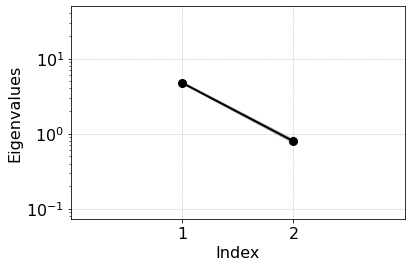

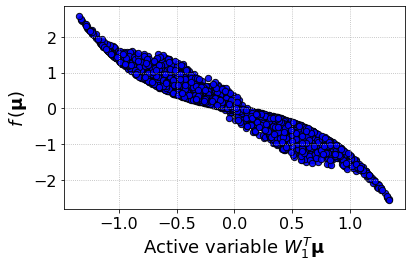

In [6]:
# Active subspace
ss = ActiveSubspaces(1)
ss.fit(inputs=x_np, gradients=df_np)

ss.plot_eigenvalues(figsize=(6, 4))

ss.plot_sufficient_summary(x_np, f, figsize=(6, 4))

In [8]:
orig_sens = as_sensitivity(ss, x_valid, example)[0]
as_sens = as_sensitivity(ss, x_valid, example)[1]

orig_sens_norm = np.empty(orig_sens.shape)
as_sens_norm = np.empty(as_sens.shape)

In [9]:
for i in range(orig_sens_norm.size):
    orig_sens_norm[i] = (orig_sens[i]/sum(orig_sens)) * 100

for i in range(as_sens_norm.size):
    as_sens_norm[i] = (as_sens[i]/sum(as_sens)) * 100

In [10]:
# NLL
nll = NonlinearLevelSet(n_layers=10,
                        active_dim=1, 
                        lr=0.01,
                        epochs=290,
                        dh=0.25,
                        optimizer=torch.optim.Adam)

x_torch = torch.as_tensor(x_np, dtype=torch.double)
df_torch = torch.as_tensor(df_np, dtype=torch.double)

In [11]:
nll.train(inputs=x_torch,
          gradients=df_torch,
          interactive=False)

epoch = 0, loss = 0.9609868312825347
epoch = 10, loss = 0.8020634612543078
epoch = 20, loss = 0.6749279553819022
epoch = 30, loss = 0.5499540540983391
epoch = 40, loss = 0.5321491839052461
epoch = 50, loss = 0.5091968909736962
epoch = 60, loss = 0.491636933429727
epoch = 70, loss = 0.4759944714978702
epoch = 80, loss = 0.4602694020800899
epoch = 90, loss = 0.44234661776684003
epoch = 100, loss = 0.42162188635389664
epoch = 110, loss = 0.39851386706273545
epoch = 120, loss = 0.37406308894737755
epoch = 130, loss = 0.3484383739498625
epoch = 140, loss = 0.32336884525946735
epoch = 150, loss = 0.30068738966903474
epoch = 160, loss = 0.28010472595430885
epoch = 170, loss = 0.26181236087447607
epoch = 180, loss = 0.246096747812559
epoch = 190, loss = 0.2325628057649324
epoch = 200, loss = 0.2210247672192083
epoch = 210, loss = 0.21155824934593487
epoch = 220, loss = 0.20421202413722886
epoch = 230, loss = 0.19869359537816575
epoch = 240, loss = 0.1946685737910032
epoch = 250, loss = 0.19176

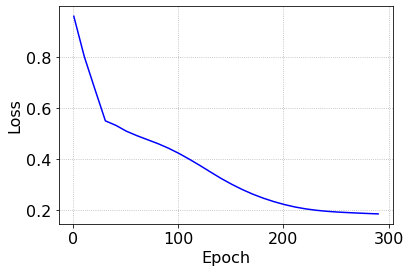

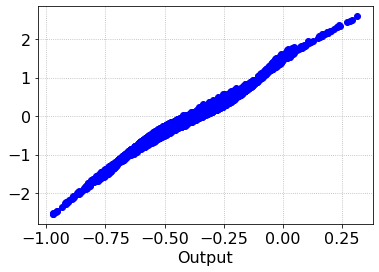

In [12]:
nll.plot_loss(figsize=(6, 4))

plot_sufficient_summary2(nll, x_torch, f, figsize=(6,4))

In [15]:
nll_sens = nll_sensitivity(nll, x_valid, example)[1]

nll_sens_norm = np.empty(nll_sens.shape)

for i in range(nll_sens_norm.size):
    nll_sens_norm[i] = (nll_sens[i]/sum(nll_sens)) * 100

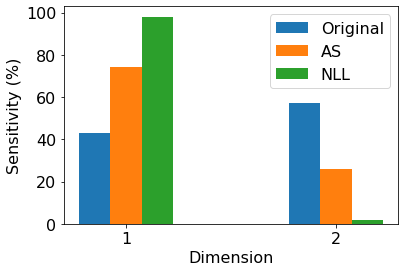

In [16]:
x_labels = [i for i in range(1, n_params+1)]
w = 0.15
pivot = np.arange(len(x_labels))
bar1 = [p - w for p in pivot]
bar2 = [p for p in pivot]
bar3 = [p + w for p in pivot]

plt.bar(bar1, orig_sens_norm, w, label="Original")
plt.bar(bar2, as_sens_norm, w, label="AS")
plt.bar(bar3, nll_sens_norm, w, label="NLL")


plt.xticks(pivot, x_labels) 
plt.xlabel("Dimension")
plt.ylabel("Sensitivity (%)")
plt.legend()

plt.show()

In [17]:
print(orig_sens_norm)
print(as_sens_norm)
print(nll_sens_norm)

[42.80952617 57.19047383]
[74.04278911 25.95721089]
[98.05926955  1.94073045]


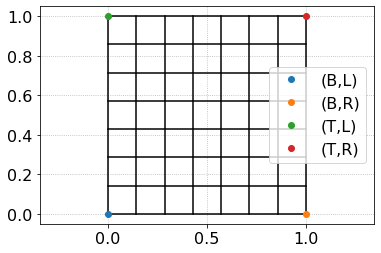

In [18]:
xx = np.linspace(0.0, 1.0, num=8)
yy = np.linspace(0.0, 1.0, num=8)
xxx, yyy = np.meshgrid(xx, yy)
mesh = np.concatenate((np.reshape(xxx, (8**2, 1)), np.reshape(yyy, (8**2, 1))), axis=1)
gridplot(mesh, Nx=8, Ny=8)

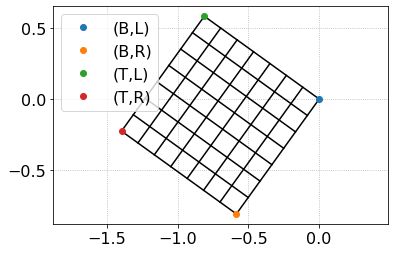

In [19]:
y, z = ss.transform(mesh)
grid_as = np.hstack((y,z))
gridplot(grid_as, Nx=8, Ny=8)

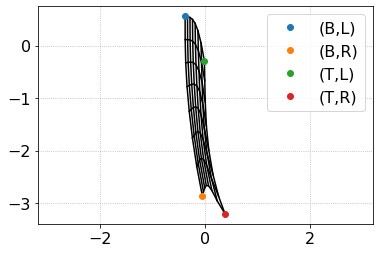

In [20]:
grid_torch = nll.forward(torch.from_numpy(mesh))
grid_nll = grid_torch.detach().numpy()
gridplot(grid_nll, Nx=8, Ny=8)